In [79]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 16})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

import zarr
import dask
from timeit import default_timer as timer
from numba import njit



In [80]:
def test(x, window, missing):
    """Standard Normal Homogeneity Test (SNHT) with a running window
    Wrapper function for numba_snhtmov

    Args:
        x (np.ndarray) : input data
        window (int) : window size (in days)
        missing (int) : allowed missing values (in days)
    Returns:
        np.ndarray : SNHT
    """

    snhtparas = np.asarray([window, missing, 10])
    tsa = np.zeros(x.shape[0])
    tmean = np.zeros(x.shape[0])
    tsquare = np.zeros(x.shape[0])
    count = np.zeros(x.shape[0], dtype=np.int32)

    numba_snhtmov(np.squeeze(np.asarray(x)),
                  tsa,
                  snhtparas,
                  count,
                  tmean,
                  tsquare)

    return tsa


@njit
def numba_snhtmov(t, tsa, snhtparas, count, tmean, tsquare):
    """Standard Normal Homogeneity Test Moving Window

    t         = np.random.randn(1000)
    snhtparas = np.asarray([100,50,10])
    tsa       = np.zeros(1000)
    tmean     = np.zeros(1000)
    tsquare   = np.zeros(1000)
    count     = np.zeros(1000,dtype=np.int32)

    Output: tsa
    """
    n = snhtparas[0]
    max_miss = snhtparas[1]
    # ninc=snhtparas[2]

    ni = t.shape[0]
    good = 0
    tmean[0] = 0.
    tsquare[0] = 0.
    for j in range(ni):
        count[j] = 0
        # compare_lists if nan ?
        if t[j] == t[j]:
            if good > 0:
                tmean[good] = tmean[good - 1] + t[j]
                tsquare[good] = tsquare[good - 1] + t[j] * t[j]
            else:
                tmean[good] = t[j]
                tsquare[good] = t[j] * t[j]
            good += 1
        if good > 0:
            count[j] = good - 1

    if good > n - 2 * max_miss:
        rm = int(n / 2)  # needs to be an integer
        # k 1460/2=730 - 650=80, n-80
        for k in range(rm - max_miss, ni - (rm - max_miss)):
            xm = k - rm  # 80-730
            if xm < 0:
                xm = 0
            xp = k + rm
            if xp > ni - 1:
                xp = ni - 1
            if (count[k] - count[xm] > rm - max_miss) and (count[xp] - count[k] > rm - max_miss):
                x = (tmean[count[k]] - tmean[count[xm]]) / (count[k] - count[xm])  # Mittelwert 1 Periode
                y = (tmean[count[xp]] - tmean[count[k]]) / (count[xp] - count[k])  # Mittelwert 2 Periode
                xy = (tmean[count[xp]] - tmean[count[xm]]) / (count[xp] - count[xm])  # Mittelwert ganze Periode

                sig = (tsquare[count[xp]] - tsquare[count[xm]]) / (count[xp] - count[xm])  # t*t ganze Periode
                if sig > xy * xy:
                    sig = np.sqrt(sig - xy * xy)  # standard deviation of the whole window
                    # n1 * (m1-m)**2 + n2 * (m2-m)**2 / stddev
                    tsa[k] = ((count[k] - count[xm]) * (x - xy) * (x - xy) + (count[xp] - count[k]) * (y - xy) * (
                            y - xy)) / (sig * sig)
                else:
                    tsa[k] = 0.
    return

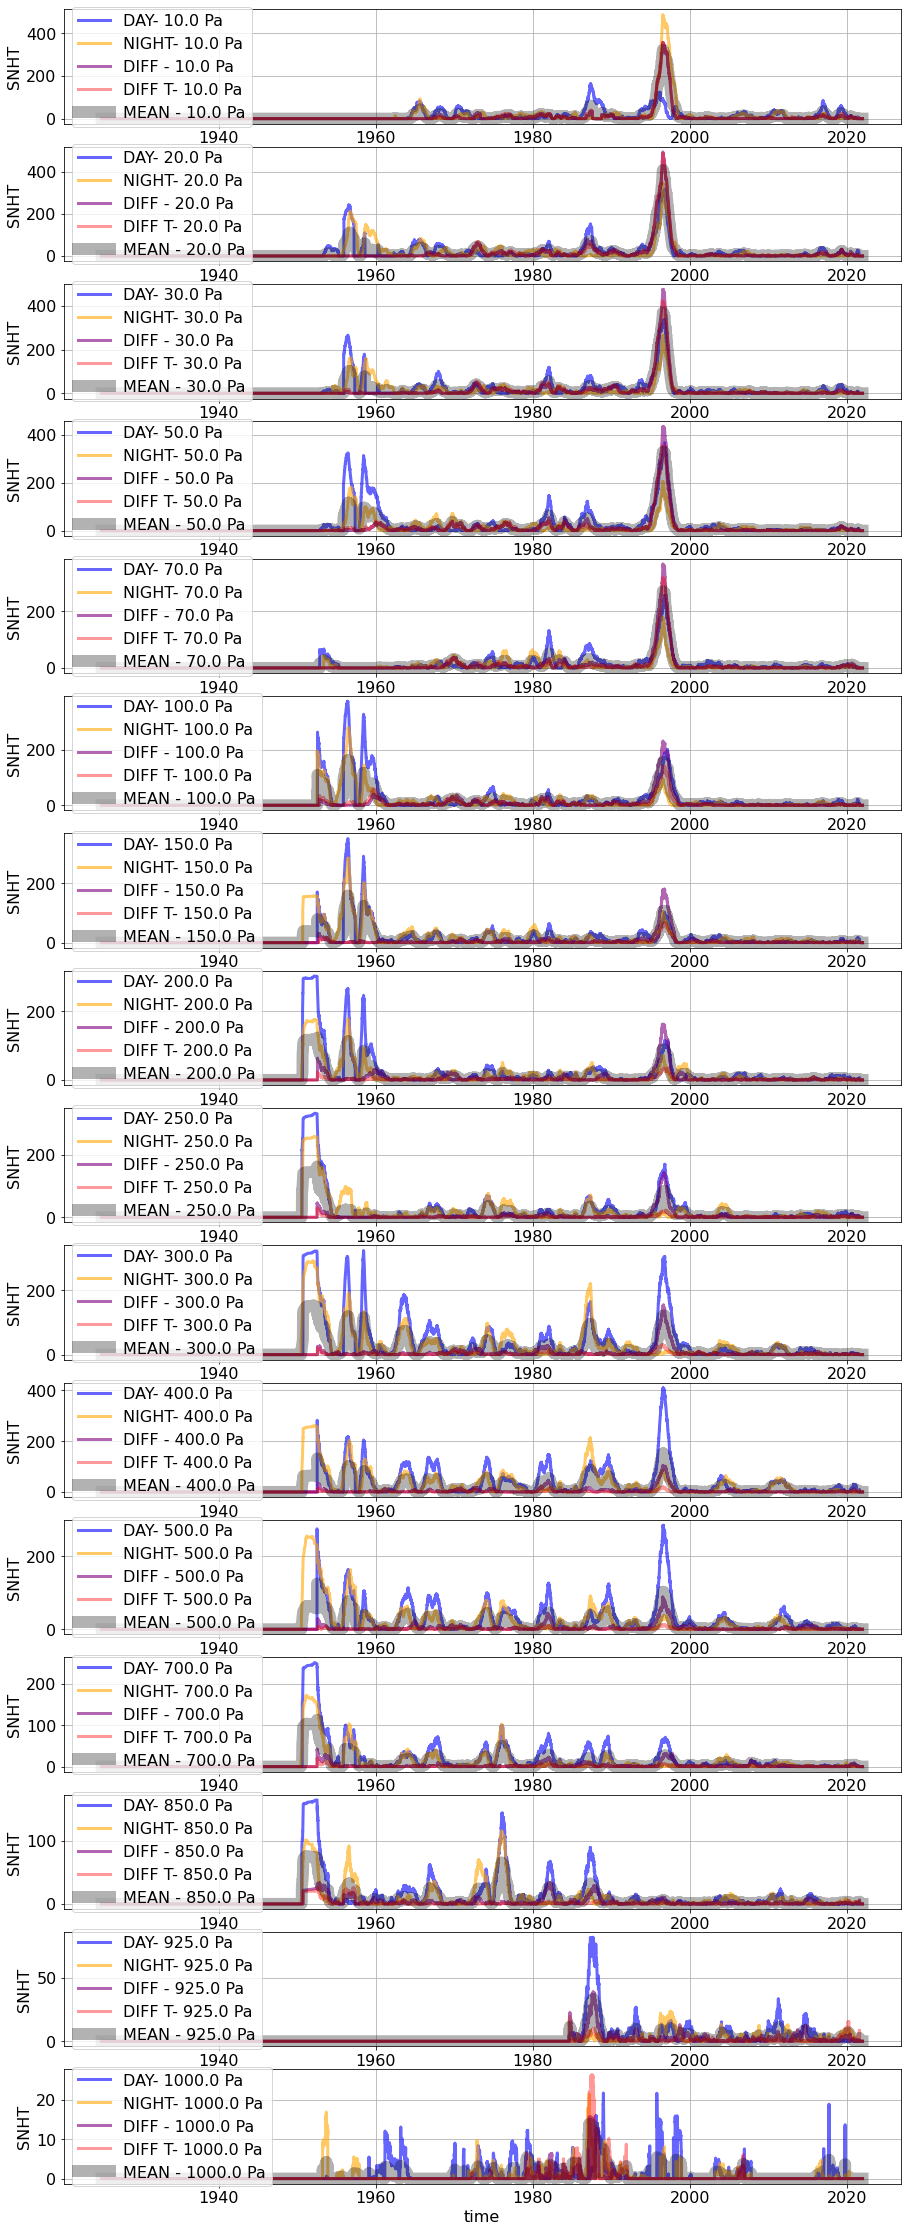

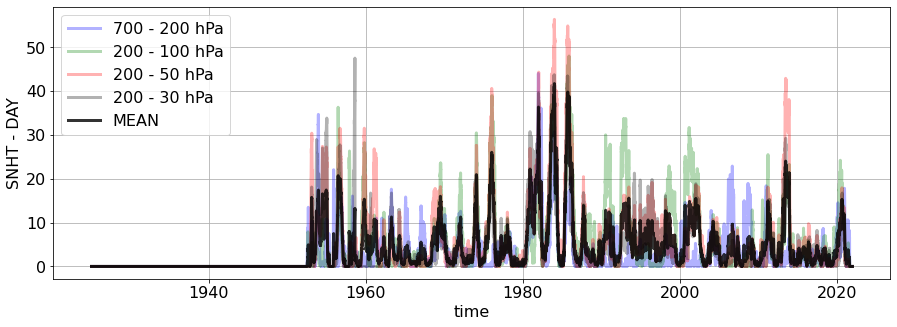

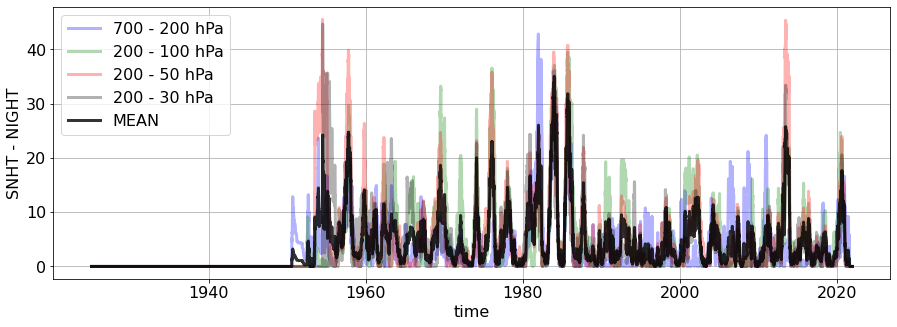

In [95]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]
files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged*')
df = xr.open_dataset(files[0])

window = 1460  # means 4 years on daily basis
missing = 600

df_night = df[dict(hour=0)]
df_day = df[dict(hour=1)]

fig, ax = maplt.subplots(len(stdplevs), 1, figsize = (15,40))
for i in range(len(stdplevs)):
    df_day_snht = df_day[dict(pressure=i)]
    df_night_snht = df_night[dict(pressure=i)]
    snht_day = test(np.array(df_day_snht.era5_fgdep), window, missing)
    snht_night = test(np.array(df_night_snht.era5_fgdep), window, missing)
    snht_diff_dn = test(np.array(df_day_snht.era5_fgdep)-np.array(df_night_snht.era5_fgdep), window, missing)
    snht_diff_dn_t = test(np.array(df_day_snht.temperatures)-np.array(df_night_snht.temperatures), window, missing)
    
    ax[i].plot(np.array(df_snht.datum),snht_day,color = 'blue', alpha = 0.6, label='DAY- ' + str(stdplevs[i]) + ' Pa', )
    ax[i].plot(np.array(df_snht.datum),snht_night,color = 'orange', alpha = 0.6, label='NIGHT- ' + str(stdplevs[i]) + ' Pa', )
    ax[i].plot(np.array(df_snht.datum),snht_diff_dn,color = 'purple', alpha = 0.6, label='DIFF - ' + str(stdplevs[i]) + ' Pa', )
    ax[i].plot(np.array(df_snht.datum),snht_diff_dn_t,color = 'red', alpha = 0.4, label='DIFF T- ' + str(stdplevs[i]) + ' Pa', )
    mean_snht = (np.array(snht_day) + np.array(snht_night) + np.array(snht_diff_dn) + np.array(snht_diff_dn_t))/4.
    ax[i].plot(np.array(df_snht.datum),mean_snht,color = 'black', alpha = 0.3, linewidth = 12, label='MEAN - ' + str(stdplevs[i]) + ' Pa', )
    ax[i].set_ylabel('SNHT')
    ax[i].set_xlabel('time')
    ax[i].legend(loc='center left')
    ax[i].grid()
maplt.show()
maplt.close()


day_snht_700_200 = test(np.array(df_day[dict(pressure=12)].temperatures) - np.array(df_day[dict(pressure=7)].temperatures), window, missing)
day_snht_200_100 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=5)].temperatures), window, missing) 
day_snht_200_50 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=3)].temperatures), window, missing) 
day_snht_200_30 = test(np.array(df_day[dict(pressure=7)].temperatures) - np.array(df_day[dict(pressure=2)].temperatures), window, missing) 

fig, ax = maplt.subplots(1, figsize = (15,5))
ax.plot(np.array(df_day.datum),day_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
ax.plot(np.array(df_day.datum),day_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
ax.plot(np.array(df_day.datum),day_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
ax.plot(np.array(df_day.datum),day_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
mean_day = (np.array(day_snht_700_200) + np.array(day_snht_200_100) + np.array(day_snht_200_50) + np.array(day_snht_200_30))/4.
ax.plot(np.array(df_day.datum),mean_day, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )
ax.set_ylabel('SNHT - DAY')
ax.set_xlabel('time')
ax.legend()
ax.grid()
maplt.show()
maplt.close()

night_snht_700_200 = test(np.array(df_night[dict(pressure=12)].temperatures) - np.array(df_night[dict(pressure=7)].temperatures), window, missing)
night_snht_200_100 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=5)].temperatures), window, missing) 
night_snht_200_50 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=3)].temperatures), window, missing) 
night_snht_200_30 = test(np.array(df_night[dict(pressure=7)].temperatures) - np.array(df_night[dict(pressure=2)].temperatures), window, missing) 

fig, ax = maplt.subplots(1, figsize = (15,5))
ax.plot(np.array(df_night.datum),night_snht_700_200, color = 'blue', alpha = 0.3, label='700 - 200 hPa', )
ax.plot(np.array(df_night.datum),night_snht_200_100, color = 'green', alpha = 0.3, label='200 - 100 hPa', )
ax.plot(np.array(df_night.datum),night_snht_200_50, color = 'red', alpha = 0.3, label='200 - 50 hPa', )
ax.plot(np.array(df_night.datum),night_snht_200_30, color = 'black', alpha = 0.3, label='200 - 30 hPa', )
mean_night = (np.array(night_snht_700_200) + np.array(night_snht_200_100) + np.array(night_snht_200_50) + np.array(night_snht_200_30))/4.
ax.plot(np.array(df_night.datum),mean_night, color = 'black', alpha = 0.8, linewidth = 3, label='MEAN', )

ax.set_ylabel('SNHT - NIGHT')
ax.set_xlabel('time')
ax.legend()
ax.grid()
maplt.show()
maplt.close()

In [8]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]
window = 1460  # means 4 years on daily basis
missing = 600

LOG_EVERY_N = 50

files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/*/feedbackmerged*')
night_save = {}
night_times = {}
day_save = {}
day_times = {}
for i in stdplevs:
    night_save[i]=[]
    night_times[i]=[]
    day_save[i]=[]
    day_times[i]=[]
t0 = time.time()
for j in range(len(files)):
    if (j % LOG_EVERY_N) == 0: print(j)
    try:
        df = xr.open_dataset(files[j])
        for i in range(len(stdplevs)):
            df_new = df[dict(pressure=i)]
            if len(df_new.time) >= window:
                df_snht = df_new[dict(hour=0)]
                snht = test(np.array(df_snht.temperatures), window, missing)
                night_save[stdplevs[i]].append(np.array(snht))
                night_times[stdplevs[i]].append(np.array(df_snht.datum))

                df_snht = df_new[dict(hour=1)]
                snht = test(np.array(df_snht.temperatures), window, missing)
                day_save[stdplevs[i]].append(np.array(snht))
                day_times[stdplevs[i]].append(np.array(df_snht.datum))
    except:
        print('xxxxxxxxx', files[j], j)
        break
print(time.time()-t0)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
80.75471138954163


10.0


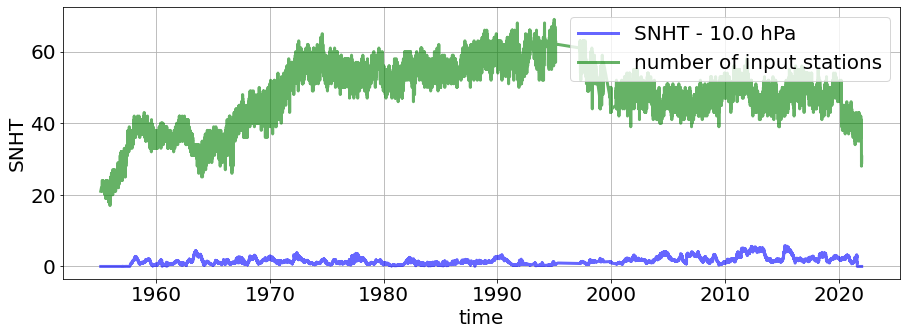

20.0


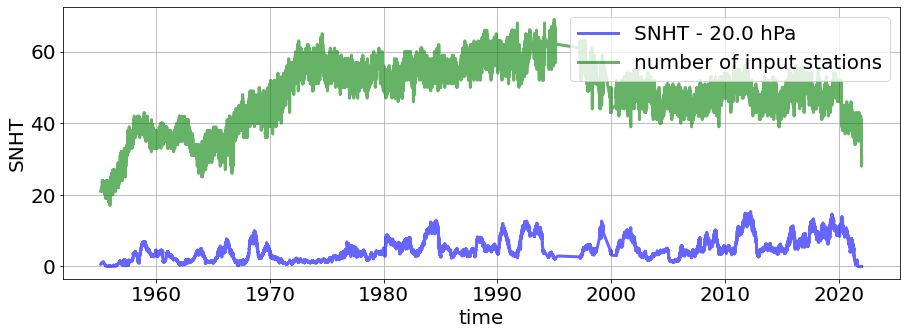

30.0


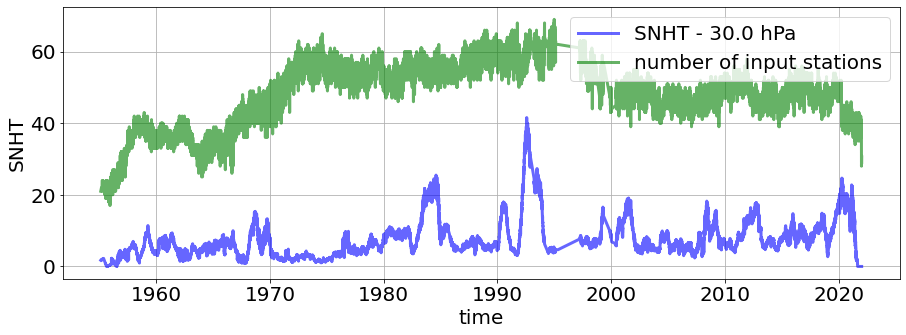

50.0


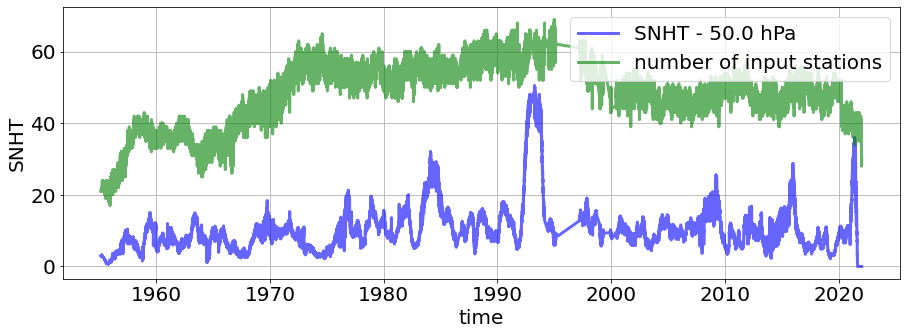

70.0


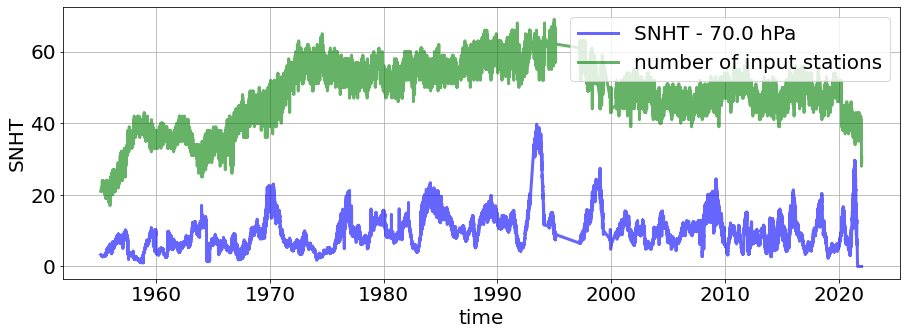

100.0


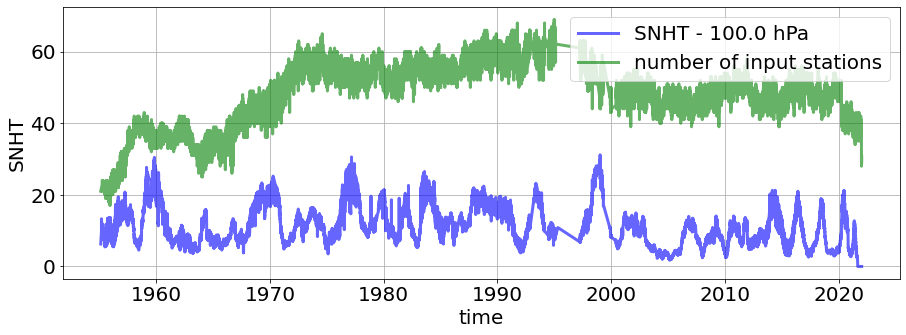

150.0


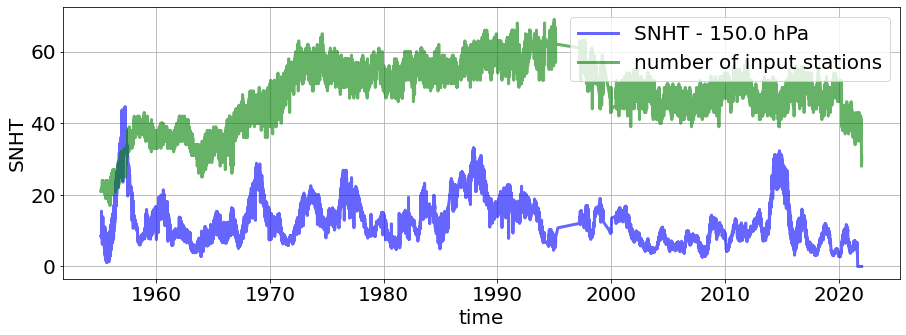

200.0


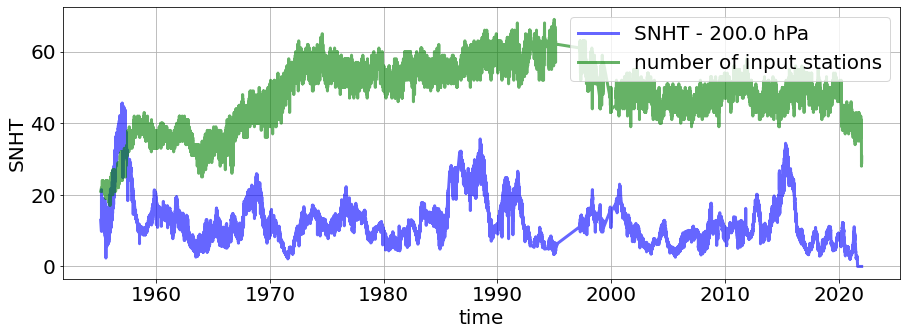

250.0


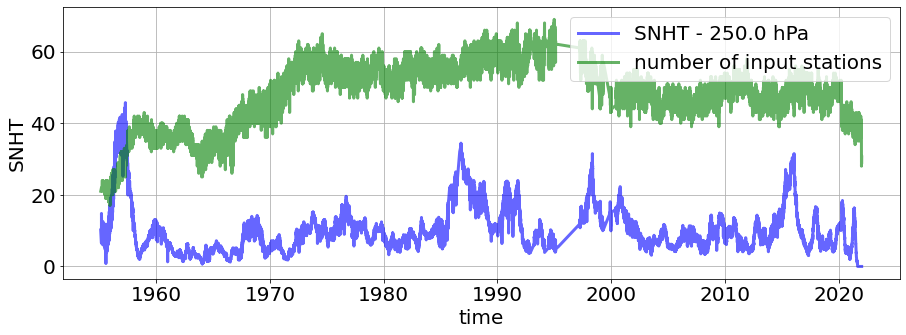

300.0


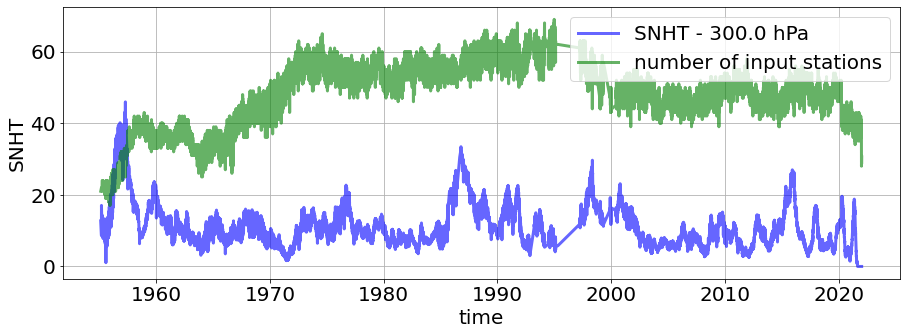

400.0


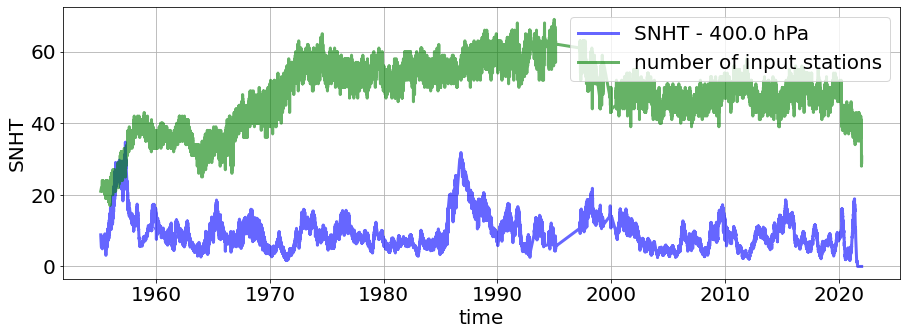

500.0


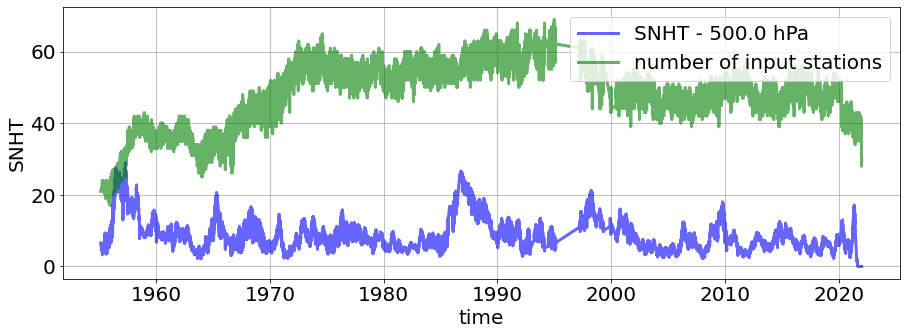

700.0


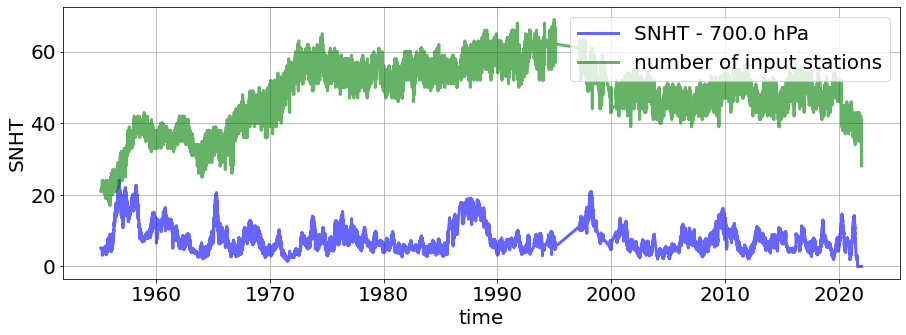

850.0


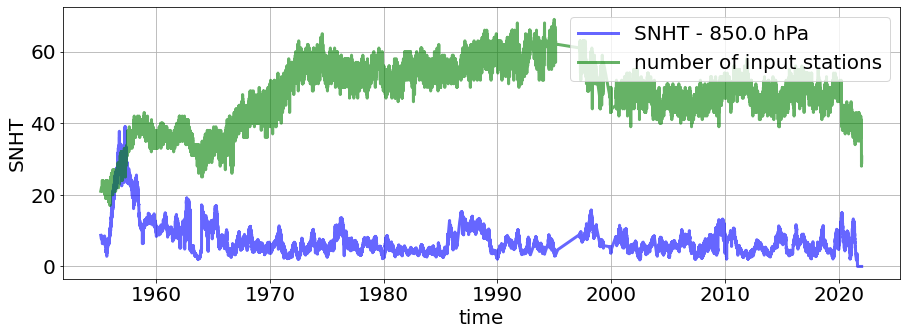

925.0


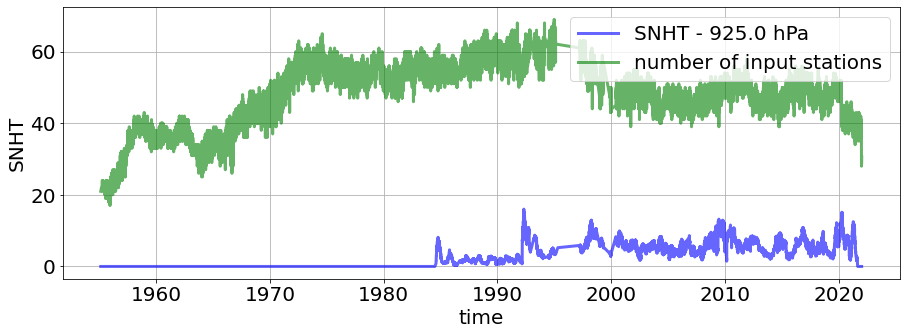

1000.0


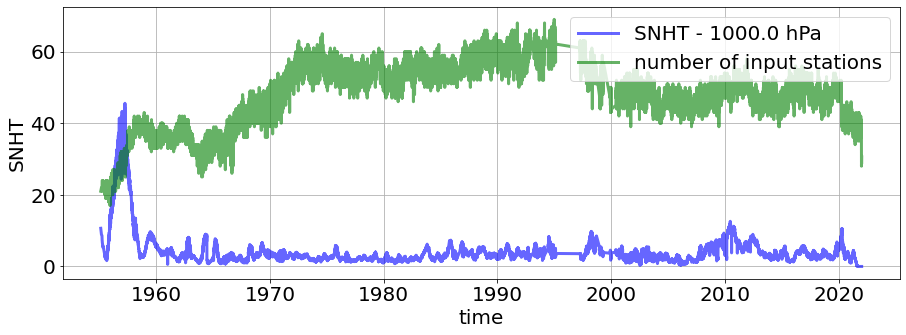

In [41]:
stdplevs = [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0]

nlen = 0
max_time = 0
for i in day_times[500]:
    if len(i) > nlen:
        max_time = i

for j in stdplevs:
    mean_snht = []
    print(j)
#     counter = 0
#     print(len(max_time))
    ic = []
    for i in max_time:
#         if (counter % 100) == 0: print(counter)
#         counter += 1
        summerizer = []
        inputcounter = 0
        for h in range(len(day_save[j][:100])):
            if i in day_times[j][h]:
                summerizer.append(day_save[j][h][day_times[j][h] == i][0])
                inputcounter += 1
        if divider != 0:
            mean_snht.append(np.nanmean(summerizer))
        else:
            mean_snht.append(0)
        ic.append(inputcounter)
                
    fig, ax = maplt.subplots(1, figsize = (15,5))
    ax.plot(np.array(max_time),np.array(mean_snht),color = 'blue', alpha = 0.6, label='SNHT - ' + str(j) + ' hPa', )
    ax.plot(np.array(max_time),np.array(ic),color = 'green', alpha = 0.6, label='number of input stations', )
    ax.set_ylabel('SNHT')
    ax.set_xlabel('time')
    ax.legend(loc='upper right')
    ax.grid()
    maplt.show()
    maplt.close()

In [10]:
len(day_save[10])

1320

In [105]:
# window = 1460  # means 4 years on daily basis
# missing = 600

# files = glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp03/011035/feedbackmerged*')
# df = xr.open_dataset(files[0]).to_dataframe()
# plevs = np.array(df.press.drop_duplicates())
# fig, ax = maplt.subplots(len(plevs), 1, figsize = (15,40))
# for i in range(len(plevs)):
#     df_new = df[df.press == plevs[i]]
#     resort = df_new.sort_values([('time')], ascending=True)
#     snht = test(np.array(resort.temperatures), window, missing)
    
#     ax[i].plot(np.array(resort.datum),snht,color = 'blue', label='SNHT - ' + str(plevs[i]) + ' Pa', )
#     ax[i].set_ylabel('SNHT')
#     ax[i].set_xlabel('time')
#     ax[i].legend(loc='upper right')
#     ax[i].grid()

# # maplt.title('SNHT')
# maplt.show()
# maplt.close()
